In [1]:
#
# Steps to run:
#
# 1.) Run the Google Drive API Python Quickstart: https://developers.google.com/drive/api/v3/quickstart/python
# 2.) Run the Google Sheets API Python Quickstart: https://developers.google.com/sheets/api/quickstart/python
# 3.) This creates .json credentials you'll need to reference below.
# 4.) Make sure this notebook is calling the correct token.json files.
# 5.) Run notebook!
#

drive_token_path = 'C:/Users/yourname/dir/drive_token.json'
sheets_token_path = 'C:/Users/yourname/dir/sheets_token.json'

In [2]:
#
# Notes:
#
# This is optimized for the Work Cycles v2.2 sheet.
#
# The following elements are hardcoded:
# A.) Filters by sheets containing 'Ultraworking' in title.
# B.) Extracting data and order of features.
#

In [3]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import display


In [5]:
# Get all Sheets using Google Drive API.

from googleapiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

item_df = []

page_token = None

store = file.Storage(drive_token_path)
creds = store.get()
        
service = build('drive', 'v3', http=creds.authorize(Http()))

while True:
    
    # Gets all Sheets
    response = service.files().list(q = "mimeType = 'application/vnd.google-apps.spreadsheet' and name contains 'Ultraworking'", 
                                    fields = 'nextPageToken, files(name, id, createdTime)',
                                    pageToken = page_token).execute()
    
    for file in response.get('files', []):
        item_df.append(file)
        
    page_token = response.get('nextPageToken', None)
    
    if page_token is None:
        break
        
# pretty up the df
items = pd.DataFrame(item_df)
items['createdTime'] = pd.to_datetime(items['createdTime'])
uw_df = items[['name', 'id', 'createdTime']]

uw_df

,name,id,createdTime
0,181209_2 Ultraworking - Work Cycles v2.2,10T2jeqAj_RO0VIZgdXNv7-l62fbn5hyqQ0XRHE8CCV4,2018-12-09 23:42:43.086
1,Copy of [BLANK] Ultraworking - Work Cycles v2.2,1v18V4rhPuMX2ItAMe9F7eWaIXPZebFAyC9a3eaCC3Ak,2018-12-09 23:43:21.627
2,Copy of [BLANK] Ultraworking - Work Cycles v2.2,1dX8220vLbrJ7u1iJqtqcPoEp5sM49vTXwld1EwqZyEw,2018-12-09 23:43:17.049
3,181120 - Ultraworking Work Cycles v2.2,11CbJEQqbCheHDE1tMrZ8PSKvgxZyy2VqrcB7_lU7G8Y,2018-11-20 21:21:42.432
4,181209 Ultraworking - Work Cycles v2.2,1nB8KjuHbTuniKNIOHHLdwo_qeUPZNU0EGTxOBBa2f58,2018-11-21 20:59:56.959
5,181207 Ultraworking - Work Cycles v2.2,1qKjagIvP9QKbphTxgspMStsy9vQqCccsSOthWtuuvdQ,2018-12-06 10:03:57.695
6,181206 Ultraworking - Work Cycles v2.2,15SM7mB8Z8Xh1yBHBbfq0eSsL58yISnb0SMZqQyzhK-Q,2018-12-06 10:03:53.487
7,181206_2 Ultraworking - Work Cycles v2.2,1R9IrCBSYvnT_NOxihRnKWLD4KFF-GMKwi-7hwOF8l34,2018-12-06 10:04:03.589
8,181205_2 Ultraworking - Work Cycles v2.2,1fCoQz9Hvl-B1yzGpj2wQ_lco_okvDNVF_i1yI2GKXk0,2018-12-05 16:31:30.726
9,181205 Ultraworking - Work Cycles v2.2,140xc3jfQrwzV72LocXKQtcJcpsx4Va-j5hNrJcqQ0Ck,2018-12-05 10:23:30.999


In [6]:
# Read work sheets from Google Sheets using ids.

# Makes new stuff 
from oauth2client import file, client, tools

# If modifying these scopes, delete the file token.json.
SCOPES = 'https://www.googleapis.com/auth/spreadsheets.readonly'

def main(spreadsheet_id):
        
    store = file.Storage(sheets_token_path)
    creds = store.get()
        
    service = build('sheets', 'v4', http = creds.authorize(Http()))
    
    sheet_metadata = service.spreadsheets().get(spreadsheetId = spreadsheet_id).execute()
    #users = sheet_metadata['sheets'][0]['protectedRanges'][0]['editors']['users']
    
    sheets = sheet_metadata.get('sheets', '')
    sheet = service.spreadsheets()
    
    titles = [x.get("properties", {}).get("title") for x in sheets]
    
    values = {}
    
    for x in titles[:3]:

        SAMPLE_RANGE_NAME = '{}!A:J'.format(x)
        
        result = sheet.values().get(spreadsheetId = spreadsheet_id,
                                    range = SAMPLE_RANGE_NAME).execute()
        
        values[x] = result.get('values', [])

    return values

In [7]:
# Concat all sheets.

prepare_df = pd.DataFrame()
main_df = pd.DataFrame()
debrief_df = pd.DataFrame()

def get_prep(subsheet_results, sheetid):
    
    header = ['accomplish_', 
              'importance_', 
              'hazards_', 
              'complete_',
              'measurability_',
              'notes_']
    
    content = [x[3] if len(x) > 2 else 'None' for x in subsheet_results[12:18]]
        
    df = pd.DataFrame(content).T  
    df.columns = header
    df['id_'] = sheetid
    
    return df

def get_main(subsheet_results, sheetid):
    
    contents = []

    for z in subsheet_results:
        if len(z) > 1:
            contents.append(z[2:])
        else:
            pass

    # Underscores to distinguish metrics from vectorized strings.
    header = ['time_',
              'cycle_',
              'goal_',
              'start_',
              'hazards_',
              'energy_',
              'morale_',
              'completion_',
              'notes_',
              'distractions_',
              'improvements_']

    df = pd.DataFrame(contents).T
    df.columns = header

    df['id_'] = sheetid
    
    return df

def get_debrief(subsheet_results, sheetid):
    
    header = ['takeaways_', 
              'bogs_', 
              'comparison_', 
              'done_', 
              'success_']
    content = [x[3] if len(x) > 2 else 'None' for x in subsheet_results[9:14]]
    
    df = pd.DataFrame(content).T  
    df.columns = header
    df['id_'] = sheetid
    
    return df

for x in uw_df['id']:
        
    try:
        
        print('{}/{} - {}'.format(uw_df.loc[uw_df['id'] == x].index.values[0], len(uw_df), uw_df.loc[uw_df['id'] == x, 'name'].values[0]))

        sheet_results = main(x)
        subsheets = list(sheet_results.keys())
        
        prepare_df = pd.concat([prepare_df, get_prep(sheet_results[subsheets[0]], x)], axis=0)
        main_df = pd.concat([main_df, get_main(sheet_results[subsheets[1]], x)], axis=0)
        debrief_df = pd.concat([debrief_df, get_debrief(sheet_results[subsheets[2]], x)], axis=0)
    
    except:
        
        print(' ', 'Exception:', uw_df.loc[uw_df['id'] == x, 'name'].values[0])
    
prepare_df.reset_index(inplace=True, drop=True)
main_df.reset_index(inplace=True, drop=True)
debrief_df.reset_index(inplace=True, drop=True)

0/14 - 181209_2 Ultraworking - Work Cycles v2.2
1/14 - Copy of [BLANK] Ultraworking - Work Cycles v2.2
  Exception: Copy of [BLANK] Ultraworking - Work Cycles v2.2
2/14 - Copy of [BLANK] Ultraworking - Work Cycles v2.2
  Exception: Copy of [BLANK] Ultraworking - Work Cycles v2.2
3/14 - 181120 - Ultraworking Work Cycles v2.2
4/14 - 181209 Ultraworking - Work Cycles v2.2
5/14 - 181207 Ultraworking - Work Cycles v2.2
6/14 - 181206 Ultraworking - Work Cycles v2.2
7/14 - 181206_2 Ultraworking - Work Cycles v2.2
8/14 - 181205_2 Ultraworking - Work Cycles v2.2
  Exception: 181205_2 Ultraworking - Work Cycles v2.2
9/14 - 181205 Ultraworking - Work Cycles v2.2
10/14 - TWG 5 Dec Demo Copy of Ultraworking - Work Cycles v2.2
11/14 - 181128 Ultraworking - Work Cycles v2.2
12/14 - 181124 Ultraworking - Work Cycles v2.2
13/14 - 181121 Ultraworking - Work Cycles v2.2


In [8]:
# Cleaning and munging

# Map energy, morale, and completion to numeric.
energy_morale_dict = {
    'High': 2,
    'Medium': 1,
    'Low': 0
}

completion_dict = {
    'Yes': 2,
    'Half': 1,
    'No': 0
}

main_df['energy_num_'] = main_df['energy_'].map(energy_morale_dict)
main_df['morale_num_'] = main_df['morale_'].map(energy_morale_dict)
main_df['completion_num_'] = main_df['completion_'].map(completion_dict)

# Time sheet was created
for x in uw_df['id']:
    time = uw_df.loc[uw_df['id'] == x, 'createdTime'].values[0]
    prepare_df.loc[prepare_df['id_'] == x, 'createdTime_'] = pd.to_datetime(time)
    main_df.loc[main_df['id_'] == x, 'createdTime_'] = pd.to_datetime(time)
    debrief_df.loc[main_df['id_'] == x, 'createdTime_'] = pd.to_datetime(time)
    
# Maps 'time' and 'cycle' to numeric values.
cycle_map = {
    'Cycle 1': 1,
    'Cycle 2': 2,
    'Cycle 3': 3,
    'Cycle 4': 4,
    'Cycle 5': 5,
    'Cycle 6': 6,
}

main_df['cycle_'] = main_df['cycle_'].map(cycle_map)
main_df['time_'] = pd.to_datetime(main_df['time_']).dt.time
main_df['hour_'] = [x.hour for x in main_df['time_']]

main_df['createdTime_'] = main_df['createdTime_'].map(lambda x: x.date())

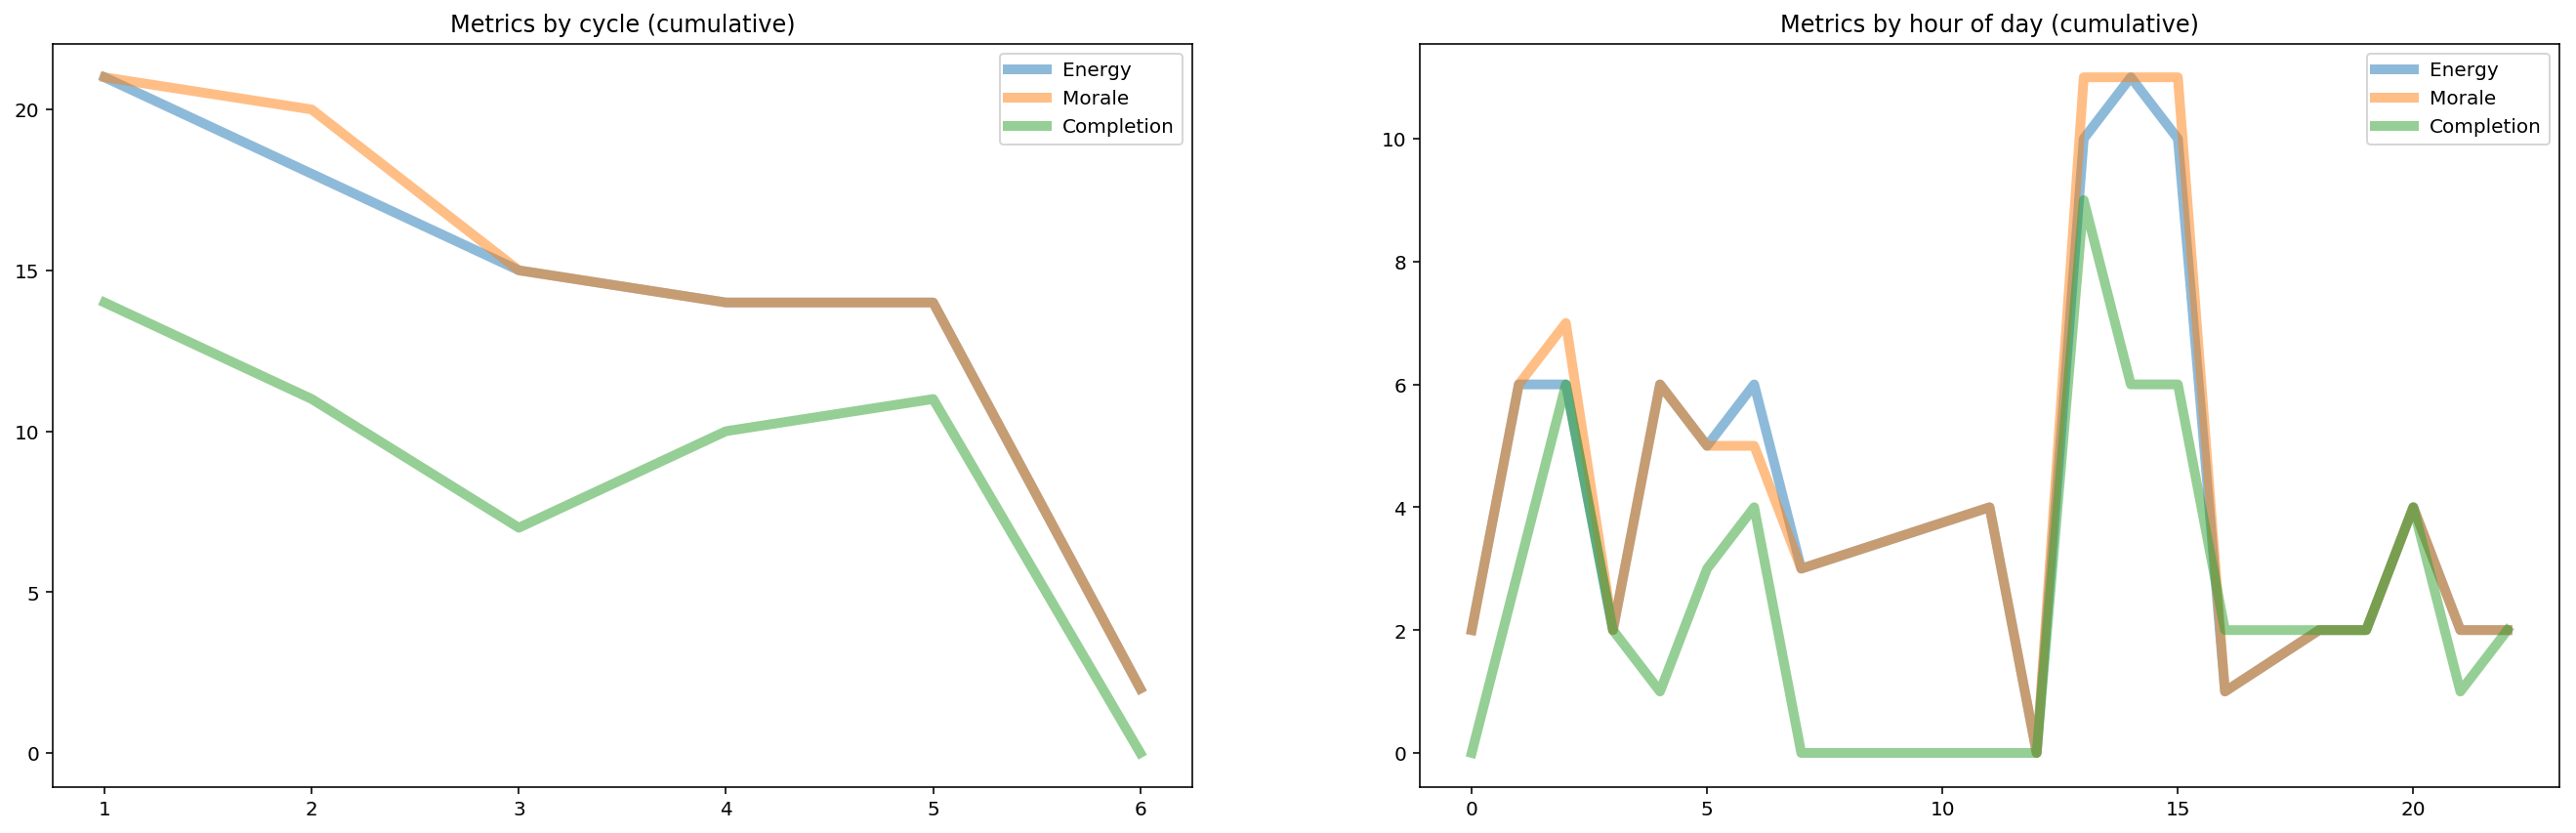

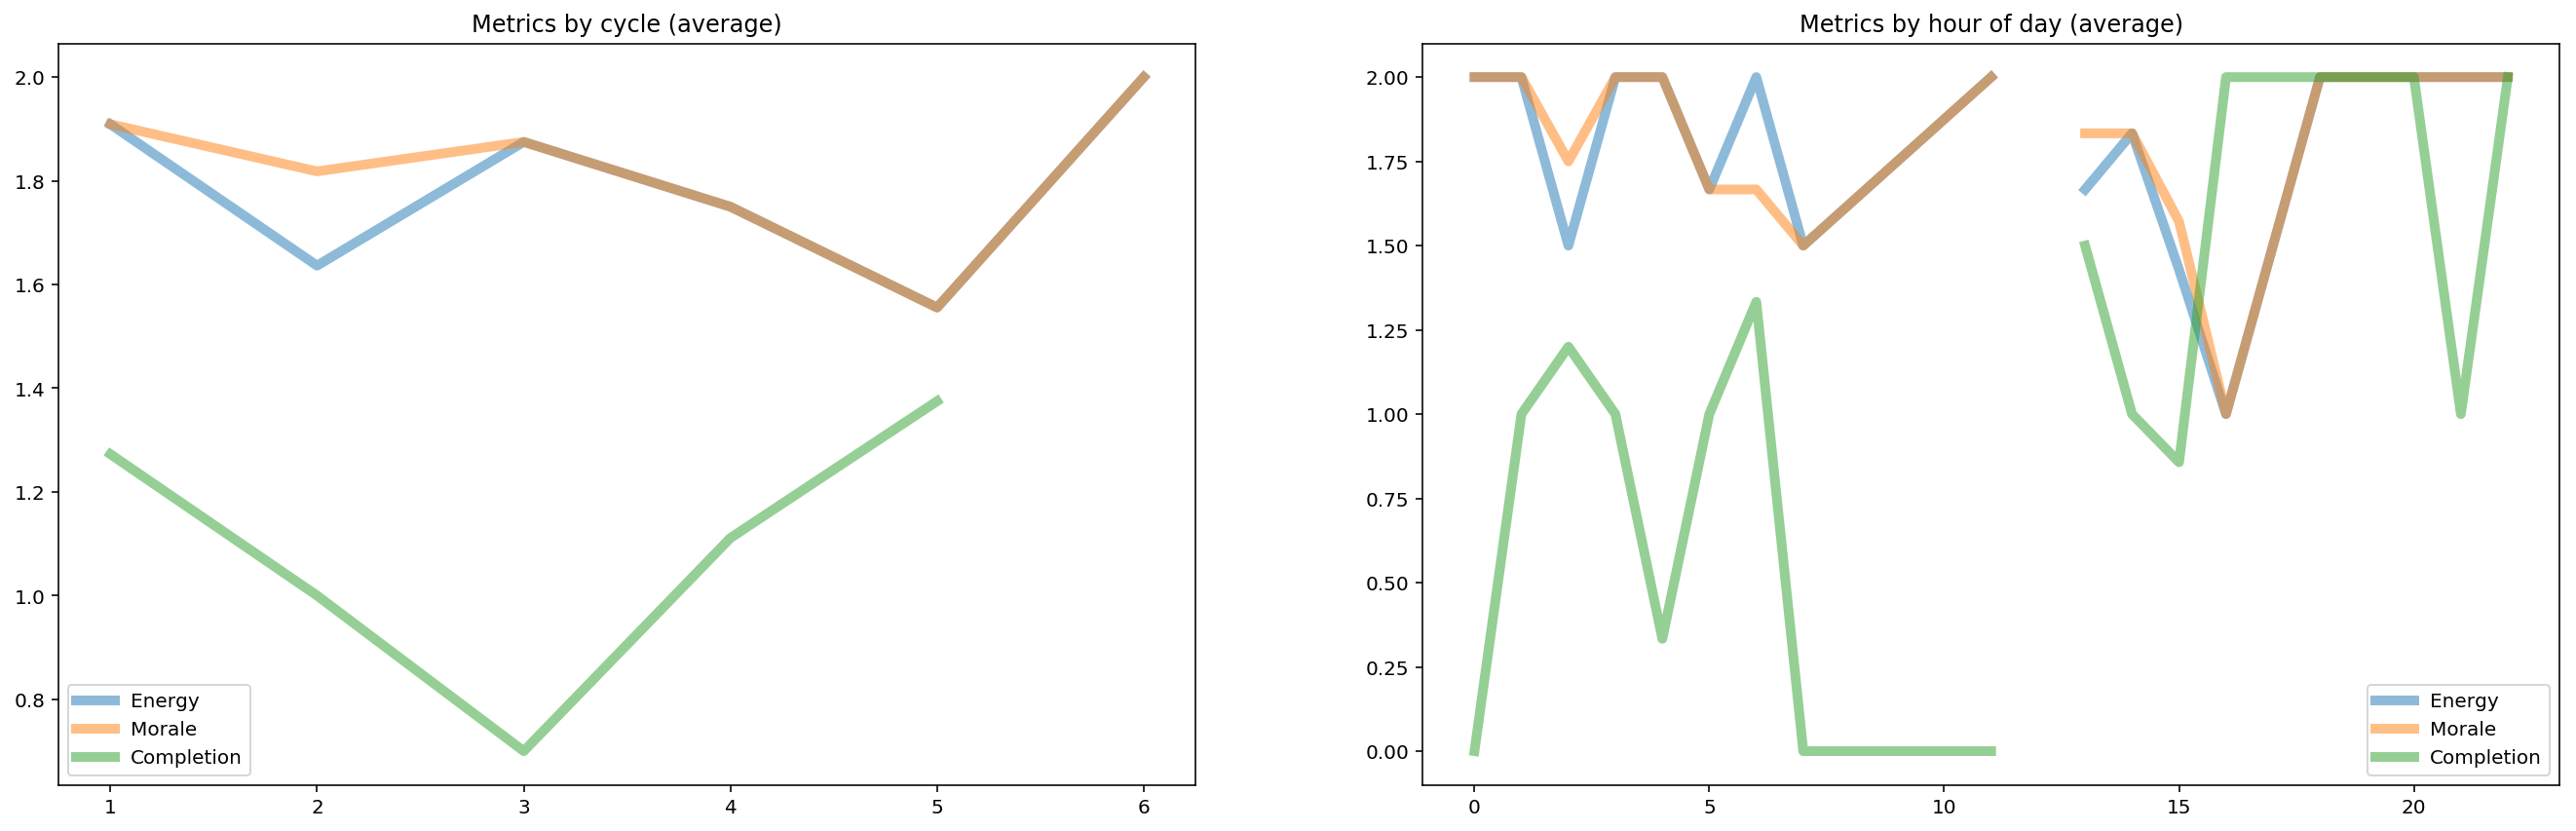

In [9]:
# Metrics over time (note cumulative vs average)

plt.figure(figsize=(23, 7))
# sp1
plt.subplot(121)
plt.plot(main_df.groupby(by='cycle_').sum()[['energy_num_', 'morale_num_', 'completion_num_']], lw=5, alpha=.5)
plt.title('Metrics by cycle (cumulative)')
plt.legend(['Energy', 'Morale', 'Completion'])

# sp2
plt.subplot(122)
plt.plot(main_df.groupby(by='hour_').sum()[['energy_num_', 'morale_num_', 'completion_num_']], lw=5, alpha=.5)
plt.title('Metrics by hour of day (cumulative)')
plt.legend(['Energy', 'Morale', 'Completion'])

plt.show()

plt.figure(figsize=(23, 7))

# sp1
plt.subplot(121)
plt.plot(main_df.groupby(by='cycle_').mean()[['energy_num_', 'morale_num_', 'completion_num_']], lw=5, alpha=.5)
plt.title('Metrics by cycle (average)')
plt.legend(['Energy', 'Morale', 'Completion'])

# sp2
plt.subplot(122)
plt.plot(main_df.groupby(by='hour_').mean()[['energy_num_', 'morale_num_', 'completion_num_']], lw=5, alpha=.5)
plt.title('Metrics by hour of day (average)')
plt.legend(['Energy', 'Morale', 'Completion'])
plt.show()

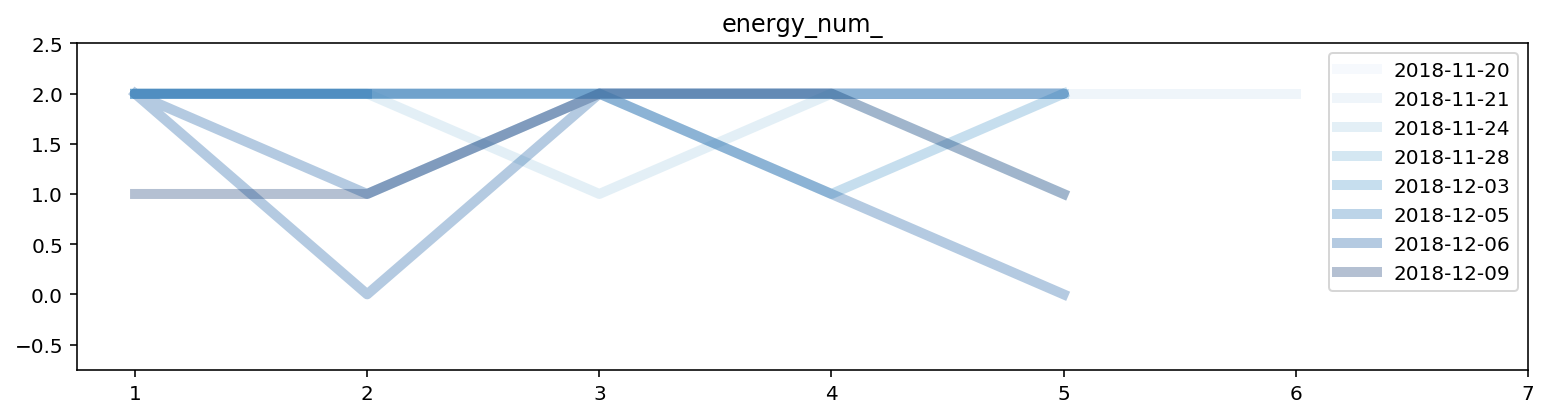

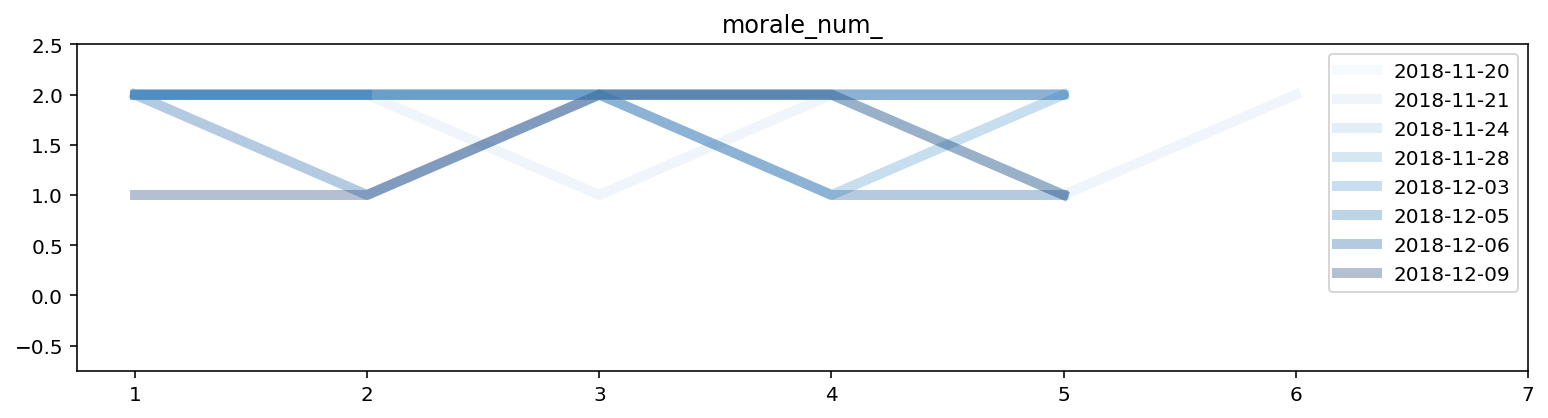

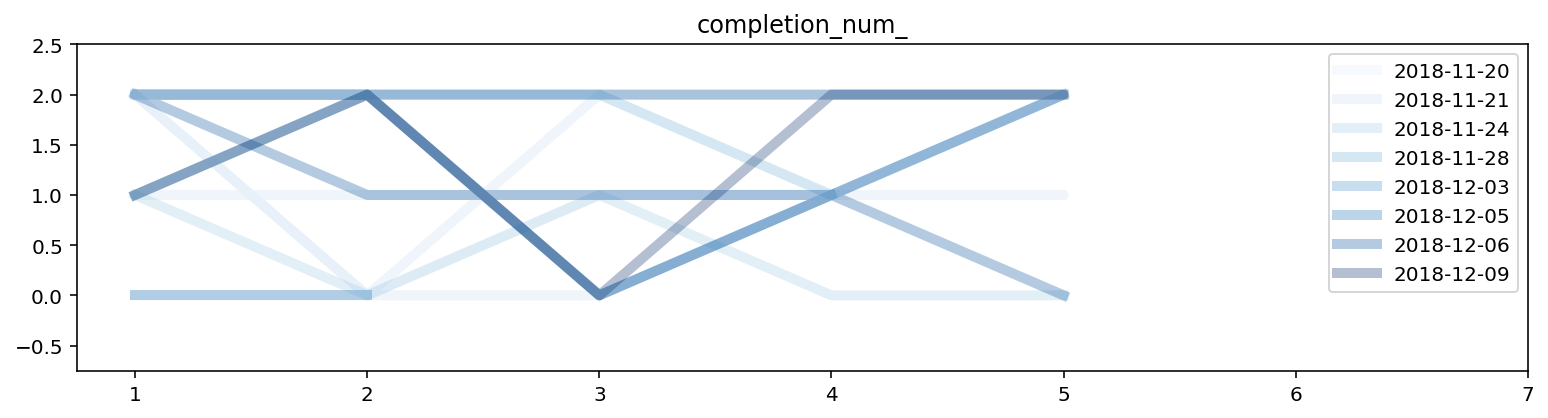

In [16]:
# Trends over cycles by metric stacked over time (darker lines = more recent)

times = sorted(main_df['createdTime_'].unique())

colors = np.linspace(.1, 1, len(times))

for metric in ['energy_num_', 
               'morale_num_', 
               'completion_num_']:
    
    plt.figure(figsize=(13, 3))
    plt.ylim(-.75, 2.5)
    plt.xlim(.75, 7)
    
    for x, y in zip(times[::-1], colors):
        
        plt.plot(main_df.loc[main_df['createdTime_'] == x, 'cycle_'],
                 main_df.loc[main_df['createdTime_'] == x, metric], 
                 alpha=.3, 
                 lw=5, 
                 color=plt.cm.Blues(y))
        
    plt.legend(times)
    plt.title(metric)
    plt.show()

In [9]:
# # Drop some features to make cleaner.
# main_df.drop(
#     [
#         'start_', 
#         'hazards_', 
#         'distractions_', 
#         'improvements_'
#     ], 
#     axis=1, 
#     inplace=True
# )

In [10]:
# # Gets wordcount for features
# def get_wordcount(feature):   
#     wordcount_feature = []   
#     for string in feature:       
#         if string == None:
#             wordcount = 0
#         else:
#             wordcount = len(string.split())
#         wordcount_feature.append(wordcount)        
#     return wordcount_feature

# # prepare_df wordcount features
# for x in [
#     'accomplish_', 
#     'importance_'
# ]:
#     prepare_df[str(x) + 'wc_'] = get_wordcount(prepare_df[x])

# # main_df wordcount features
# for x in [
#     'goal_', 
#     'notes_'
# ]:
#     main_df[str(x) + 'wc_'] = get_wordcount(main_df[x])

In [31]:
# Replaces null strings
def prep(string):
    if string == None:
        string = 'None'
    return string

#
# Currently this is grouping null values in the left-most col.
#

# Gets stats
def get_stats(main_df_column, metric):
    
    corpus = [prep(i) for i in main_df[main_df_column]]
    vec = CountVectorizer(ngram_range=(1,1), 
                          stop_words='english')
    fit_vec = vec.fit_transform(corpus)
    vec_df = pd.DataFrame(fit_vec.todense(), columns=vec.get_feature_names())
    
    # Concat with metric
    goal_df = pd.concat([main_df[metric], vec_df], axis=1)
        
    goal_df = goal_df.groupby(metric).sum().T
    goal_df = goal_df[[x for x in goal_df.columns if len(x) > 1]]
        
    print('Keywords by {} for {}:'.format(metric, main_df_column))
    
    
        
    metric_df = pd.concat([pd.DataFrame(goal_df.sort_values(by=x, ascending=False)[x].head(10)).rename_axis('Keywords').reset_index() 
                           for x in goal_df.columns],
                          axis=1)

    return metric_df

In [32]:
# Print results

freeform = [
    'goal_',
#     'start_', 
#     'hazards_', 
#     'notes_', 
#     'distractions_', 
#     'improvements_'
]

metrics = [
    'energy_',
    'morale_', 
    'completion_'
]

for x in freeform:
    for y in metrics: 
        display(get_stats(x, y))

Keywords by energy_ for goal_:


,Keywords,High,Keywords,Low,Keywords,Medium
0,metrics,6,damn,1,try,5
1,api,5,allow,1,code,3
2,add,5,god,1,example,3
3,print,5,codecademy,1,image,2
4,sheets,5,finish,1,streaming,2
5,list,4,finally,1,design,2
6,options,4,sync,1,ec2,2
7,run,4,sql,1,mounting,1
8,finish,3,model,1,cycle,1
9,drive,3,fucking,1,potentially,1


Keywords by morale_ for goal_:


,Keywords,High,Keywords,Medium
0,metrics,6,run,2
1,print,5,code,2
2,api,5,finish,2
3,sheets,5,work,2
4,add,5,try,2
5,make,4,design,2
6,code,4,image,2
7,try,4,example,2
8,options,4,streaming,2
9,list,4,notebook,1


Keywords by completion_ for goal_:


,Keywords,Half,Keywords,No,Keywords,Yes
0,make,3,model,4,continue,2
1,strategy,3,print,4,code,2
2,try,3,options,3,stuff,2
3,filter,3,run,3,debugging,2
4,metrics,3,sheets,3,list,2
5,code,3,figure,3,drive,2
6,options,3,delta,3,dte,2
7,linkedin,2,ec2,2,ec2,2
8,connect,2,available,2,streaming,2
9,check,2,metrics,2,reconcile,2
